In [1]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from scipy.special import logsumexp
import scipy as sp
import scipy.io.wavfile as wavfile
import os
from hmmlearn import hmm
import MFCC
import numpy as np
import re
import random
import pickle
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

In [3]:
def sample_gmmhmm(gmmhmm, n_sim):
    """
    Simulate from a GMMHMM.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    # Get attributes
    A = gmmhmm[0]
    weights = gmmhmm[1]
    means = gmmhmm[2]
    covars = gmmhmm[3]
    pi = gmmhmm[4]

    # Initialize lists
    states = []
    obs = []

    # Get first state from pi
    state = np.argmax(np.random.multinomial(1,pi))

    # Iterate through number of samples
    for i in range(n_sim):

      states.append(state)

      sample_component = np.argmax(np.random.multinomial(1, weights[state,:]))
      sample = np.random.multivariate_normal(means[state, sample_component, :], covars[state, sample_component, :, :])
      obs.append(sample)

      state = np.argmax(np.random.multinomial(1, A[:, state]))

    return states, obs


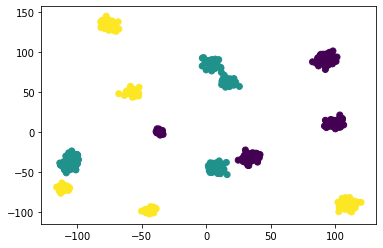

In [4]:
# Test GMM
A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], [.1, .3, .2, .1, .3]])
means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) for i in range(3)])
covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) for i in range(5)] for j in range(3)])
pi = np.array([.15, .15, .7])

# Save the model parameters
gmm = [A, weights, means, covars, pi]

states, obs = sample_gmmhmm(gmm, 900)

# PCA
pca = PCA(n_components=2)
pca.fit(obs)
obs = pca.transform(obs)

# Plot it
plt.scatter(obs[:,0], obs[:,1], c=states)
plt.show()

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

In [5]:
# !unzip Samples.zip

<ipython-input-6-dca836a15f5a>:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(f)


30
30
30
30
30


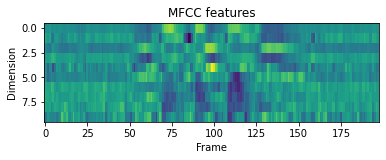

In [6]:
bio, math, polisci, psych, stats, = [], [], [], [], []
# Go through all the files and read and extract
for filename in os.listdir("Samples"):
    f = os.path.join("Samples", filename)
    if os.path.isfile(f):
      samplerate, data = wavfile.read(f)
      model = MFCC.extract(data, show=False)
      if "Biology" in filename:
        bio.append(model)
      elif "Math" in filename:
        math.append(model)
      elif "Poli" in filename:
        polisci.append(model)
      elif "Psych" in filename:
        psych.append(model)
      elif "Stat" in filename:
        stats.append(model)

# Check lengths
print(len(bio))
print(len(math))
print(len(polisci))
print(len(psych))
print(len(stats))

## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [7]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += sp.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + sp.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [15]:
# Test train split
bio_train, bio_test = tts(bio, test_size=10,train_size=20)
math_train, math_test = tts(math, test_size=10, train_size=20)
poli_train, poli_test = tts(polisci, test_size=10, train_size=20)
psych_train, psych_test = tts(psych, test_size=10, train_size=20)
stats_train, stats_test = tts(stats, test_size=10, train_size=20)

data_dict = {"bio":bio_train, "math":math_train, "poli":poli_train, "psych":psych_train, "stats":stats_train}

best_models = {}
# Find Best
for word in data_dict:
  logprob = -np.inf
  for i in range(10):
    data = data_dict[word] # Reshape data for hmmlearn's fit method
    lengths = [data[0].shape[0]] * len(data)
    data_collected = np.vstack(data)

    # Get probabilities and transition matrices
    startprob, transmat = initialize(5)
    model = hmm.GMMHMM(n_components=5, covariance_type="diag", init_params="mc") 
    model.startprob_ = startprob # Set probabilities and transition matrices
    model.transmat_ = transmat
    model.fit(data_collected) # Fit the model
    if model.monitor_.history[-1] > logprob:
      logprob = model.monitor_.history[-1]
      best_model = model

  best_models[word] = best_model

  # Save best models
  temp = {word: best_model}
  with open(word, 'wb') as out:
    pickle.dump(temp, out)



## Problem 4

Find the classification accuracies of the five GMMHMMs, and return a dictionary
where the words/phrases are the keys, and the values are the percent accuracies.

In [26]:
test_dict = {"bio":bio_test, "math":math_test, "poli":poli_test, "psych":psych_test, "stats":stats_test}
evaluation = {"bio":0, "math":0, "poli":0, "psych":0, "stats":0}

# Iterate through all the test sets
for word in test_dict:
  data = test_dict[word]

  # Iterate through each sample
  for test in data:
    score = -np.inf
    best_word = word

    # Iterate through each model
    for word2 in best_models:
      model = best_models[word2]

      # Save model and score that is the best
      if model.score(test) > score:
        score = model.score(test)
        best_word = word2
    evaluation[best_word] += 1

# Divide each by number of samples for accuracy
for word in evaluation:
  evaluation[word] /= 10

print(evaluation)

{'bio': 1.0, 'math': 1.0, 'poli': 1.0, 'psych': 1.0, 'stats': 1.0}


In [ ]:
#